In [1]:
#loading python packages
import os
import cv2
import numpy as np
from keras.models import model_from_json
import pickle
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
import matplotlib.pyplot as plt

In [2]:
#function to identify label id by giving label name
def getID(name):
    index = 0
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index   

In [3]:
#read all class labels from dataset
labels = []
for root, dirs, directory in os.walk('Dataset'):
    for j in range(len(directory)):
        name = os.path.basename(root)
        if name not in labels:
            labels.append(name)
print("Available Class Labels in Dataset\n\n")            
print(str(labels)+"\n\n")

Available Class Labels in Dataset


['Action Comics v2', 'All-Star Western v3', 'Animal Man', 'Aquaman and the Others', 'Arkham Manor', 'Bat-Mite', 'Batman & Robin Eternal', 'Batman Incorporated v2', 'Batwoman', 'Birds Of Prey', 'Bizarro', 'Black Canary v3']




(5710, 64, 64, 3)
(5710, 12)

Total Images found in dataset : 5710

Total classes found in dataset : 12



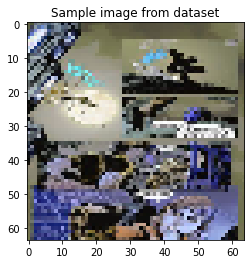

In [4]:
#loading all dataset images from numpy array to avoid processing of images again and again
X = np.load('cnn_train_model/X.txt.npy')
Y = np.load('cnn_train_model/Y.txt.npy')
print(X.shape)
print(Y.shape)
print("\nTotal Images found in dataset : "+str(X.shape[0])+"\n")
print("Total classes found in dataset : "+str(Y.shape[1])+"\n")
testImage = X[0]
plt.imshow(testImage)
plt.title('Sample image from dataset')
plt.show()
#displaying number of images availabel in dataset with image size and colors

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 25)        20025     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 25)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 50)        31300     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 50)         0         
 2D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 50)        

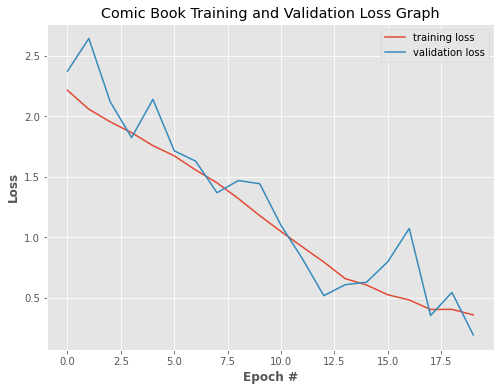

In [5]:
#splitting dataset into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
#check CNN model already build or not. if build then load from give weights file
if os.path.exists('cnn_train_model/model.json'):
    with open('cnn_train_model/model.json', "r") as json_file:
        cnn_model = json_file.read()
        model = model_from_json(cnn_model)
    model.load_weights("cnn_train_model/modelWeights.h5")
    model.make_predict_function()   
    print(model.summary())
else:#if model dose not exists then start training
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
    model.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(units=100, activation='relu'))
    model.add(Dense(units=100, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(units=Y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    history = model.fit(X, Y, batch_size=16, epochs=20, validation_data=(X_test, y_test),shuffle=True, verbose=2)
    model.save_weights('cnn_train_model/modelWeights.h5')            
    model_json = model.to_json()
    with open("cnn_train_model/model.json", "w") as jsonFile:
        jsonFile.write(model_json)
    jsonFile.close()    
    f = open('cnn_train_model/accuracy.pckl', 'wb')
    pickle.dump(history.history, f)
    f.close()
    
#calculating training and validation accuracy and loss    
file = open('cnn_train_model/accuracy.pckl', 'rb')
pickleData = pickle.load(file)
file.close()
accuracy = pickleData['accuracy']
loss  = pickleData['loss']
val_accuracy = pickleData['val_accuracy']
val_loss = pickleData['val_loss']
print("\nCNN Comic Book Training Accuracy = "+str(accuracy[19]))    
print("CNN Comic Book Training Loss = "+str(loss[19])) 
print("CNN Comic Book Validation Accuracy = "+str(val_accuracy[19]))    
print("CNN Comic Book Validation Loss = "+str(val_loss[19])) 
#displaying loss graph
N = np.arange(0, 20)
plt.style.use("ggplot")
plt.figure(figsize = [8,6])
plt.plot(N, loss, label="training loss")
plt.plot(N, val_loss, label="validation loss")
plt.title("Comic Book Training and Validation Loss Graph")
plt.xlabel("Epoch #", weight='bold')
plt.ylabel("Loss", weight='bold')
plt.legend()



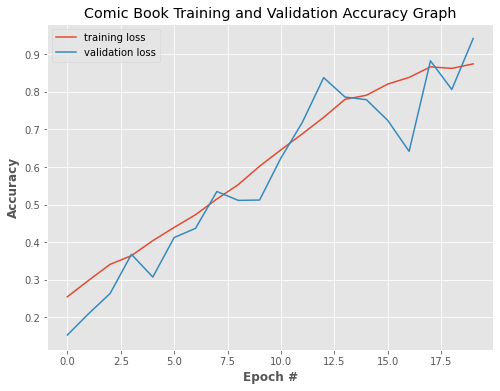

In [6]:
#displaying accuracy graph
N = np.arange(0, 20)
plt.style.use("ggplot")
plt.figure(figsize = [8,6])
plt.plot(N, accuracy, label="training loss")
plt.plot(N, val_accuracy, label="validation loss")
plt.title("Comic Book Training and Validation Accuracy Graph")
plt.xlabel("Epoch #", weight='bold')
plt.ylabel("Accuracy", weight='bold')
plt.legend()



Comic Book CNN Confusion Matrix : [[255   0   0   3   0   0   2   3   0   0   1   2]
 [  2 144   0   0   0   0   1   1   1   0   0   0]
 [  2   2 111   0   0   0   1   0   1   1   0   0]
 [  1   0   0  36   0   0   0   0   0   0   0   0]
 [  0   1   0   0  26   0   1   0   0   0   0   0]
 [  0   0   0   0   0  23   0   0   0   0   0   0]
 [  1   0   0   0   0   1  94   0   0   1   1   2]
 [  0   2   0   0   0   0   0  64   0   0   0   1]
 [  3   0   1   2   2   0   0   3 142   4   1   0]
 [  3   0   0   1   0   0   0   1   2 117   0   0]
 [  0   0   0   0   0   0   1   0   0   0  22   0]
 [  1   0   0   0   0   0   5   0   0   0   1  42]]



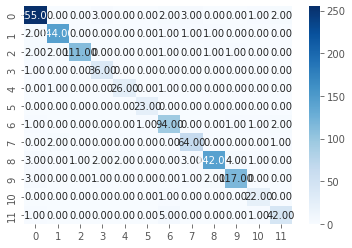

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
prediction = model.predict(X_test)
y_test = np.argmax(y_test, axis=1)
prediction = np.argmax(prediction, axis=1)
confusion_matrix = confusion_matrix(y_test,prediction)
print("\nComic Book CNN Confusion Matrix : "+str(confusion_matrix)+"\n")
sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap='Blues')
plt.show()

0


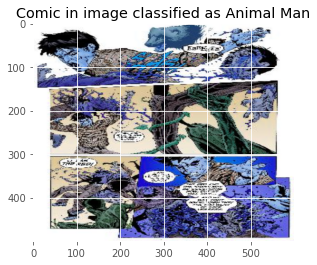

1


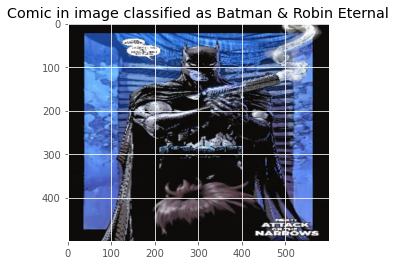

2


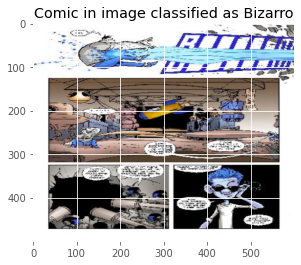

3


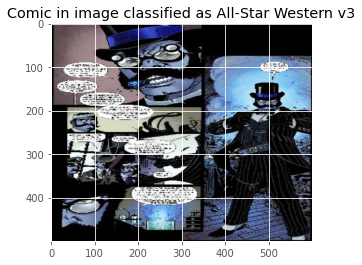

4


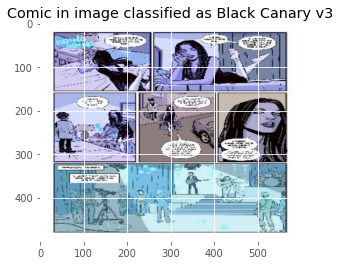

In [8]:
testImages = ['1.jpg','2.jpg','3.jpg','4.jpg','5.jpg']
for i in range(len(testImages)):
    print(i)
    image = cv2.imread('testImages/'+testImages[i])
    image = cv2.resize(image, (64,64))
    image = image.reshape(1,64,64,3)
    image = np.asarray(image)
    image = image.astype('float32')
    image = image/255
    predict_comic = model.predict(image)
    predict_comic = np.argmax(predict_comic)
    predict_comic = labels[predict_comic]
    image = cv2.imread('testImages/'+testImages[i])
    image = cv2.resize(image, (600,500))
    plt.imshow(image)
    plt.title('Comic in image classified as '+predict_comic)
    plt.show()